In [2]:
#import all the libraries

import sys
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Any,List,Dict,Union
#for the imbalance data required libraries
#A balanced random forest randomly under-samples each boostrap sample to balance it.
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score

import time as timer

from sklearn.inspection import permutation_importance

In [3]:
# open dataset

df = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(df)
print("Data Shape : {}".format(data.shape))
data.head()

Data Shape : (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())
df = data.drop_duplicates(subset='id')
df = df.drop(['id'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [7]:
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [8]:
# number of 'other' is very small, converting the value to 'Male'
data['gender']=data['gender'].replace('Other','Male')

In [9]:
data.replace({ 'gender': {'Male':1 ,'Female':0}} ,inplace=True)
data.replace({ 'ever_married': {'No':0 ,'Yes':1}} ,inplace=True)
data.replace({ 'Residence_type': {'Rural':0 ,'Urban':1}} ,inplace=True)
data.replace({ 'smoking_status': {'Unknown':0 ,'never smoked':1,'formerly smoked':2,'smokes':3}} ,inplace=True)
data.replace({ 'work_type': {'Private':0 ,'Self-employed':1,'children':2,'Govt_job':3,'Never_worked':4}} ,inplace=True)

In [10]:
data.dtypes

id                     int64
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

<AxesSubplot:title={'center':'Correlation map for variables'}>

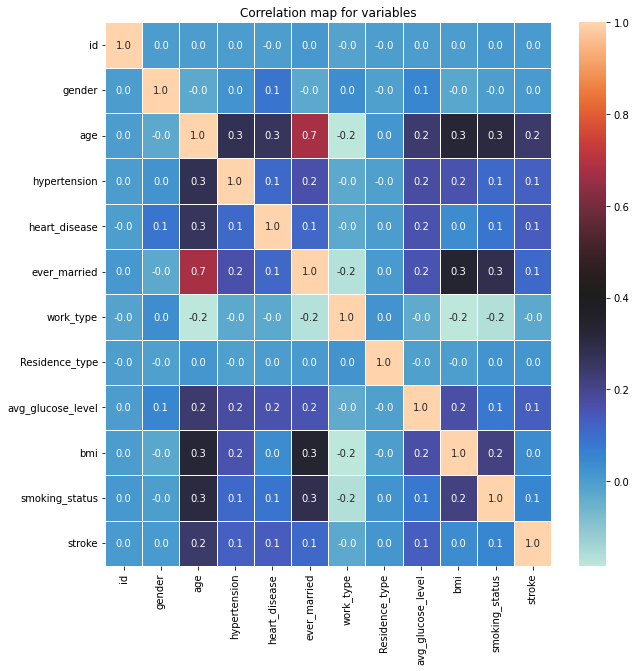

In [11]:
#Inter Feature correlation
f,correlation = plt.subplots(figsize=(10,10))
correlation.set_title('Correlation map for variables')
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=correlation,cmap="icefire")

With No Stroke : 4861
With Stroke : 249


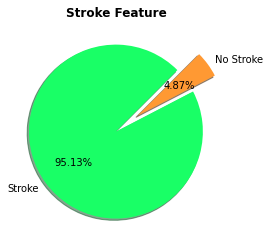

In [12]:
occurance = data['stroke'].value_counts()
data_stroke = data['stroke']
fig,ax = plt.subplots()
labels = ("Stroke","No Stroke")
values = data['stroke'].value_counts().tolist()  #tolist is used to convert data elements in a list
ax.pie(x=values,labels=labels,autopct="%1.2f%%", shadow=True, startangle=45,explode=[0.01, 0.3],colors=['#19FF66','#FF9933'])
ax.set_title("Stroke Feature", fontdict={'fontsize': 12},fontweight ='bold')
fig.set_facecolor('white')
print("With No Stroke : {}".format(occurance[0]))
print("With Stroke : {}".format(occurance[1]))

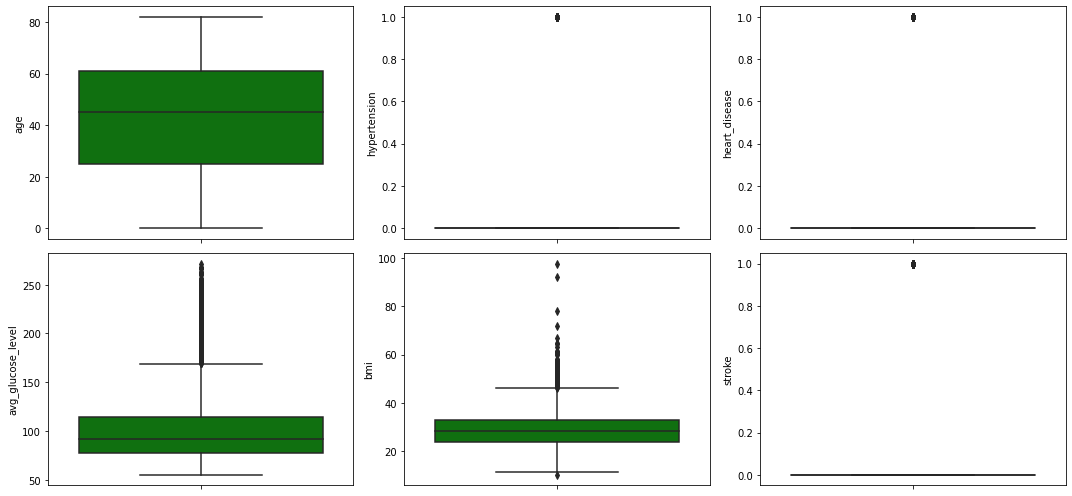

In [13]:
nums = list(df.select_dtypes(include=['int64','float64']))
plt.figure(figsize=(15, 7))
for i in range(0, len(nums)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[nums[i]],color='green',orient='v')
    plt.tight_layout()

Data Preprocessing

     HANDLE IMBALANCED CLASS

In [14]:
# separate feature and target
X = data.drop(columns = ['stroke'])
y = data['stroke']

In [15]:
# using SMOTE Techniqe
sm = SMOTE(random_state=111)
X_sm , y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{y_sm.value_counts(normalize=True)}''')

Shape of X before SMOTE:(5110, 11)
Shape of X after SMOTE:(9722, 11) 


Target Class distributuion before SMOTE:
0    0.951272
1    0.048728
Name: stroke, dtype: float64
Target Class distributuion after SMOTE :
1    0.5
0    0.5
Name: stroke, dtype: float64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm,
    y_sm,
    test_size = .2,
    random_state = 111)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7777, 11), (7777,), (1945, 11), (1945,))

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
#X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

In [18]:
def sensitivity_specificity(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TN = conf_matrix[0][0]
    #Calculate the sensitivity
    sensitivity  = TP /(TP +FN)
    #Calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

SUPPORT VECTOR MACHINE

In [20]:
start = timer.time()
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)


Finished training within 5.46 seconds


In [21]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_svm)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_svm)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_svm)))
# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_svm)
rec_svm = recall_score(y_test,y_svm)
f1_svm = f1_score(y_test,y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))

Classification report for SVM: 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       948
           1       0.85      0.92      0.88       997

    accuracy                           0.88      1945
   macro avg       0.88      0.88      0.88      1945
weighted avg       0.88      0.88      0.88      1945

Confusion matrix for SVM: 
[[789 159]
 [ 82 915]]
Accuracy score for SVM: 0.88
Precision score for SVM: 0.85
Recall score for SVM: 0.92
F1 score for SVM: 0.88


In [22]:
# calculate sensitivity, specificity, and auc
sensitivity_svm,specificity_svm = sensitivity_specificity(y_test,y_svm)
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:,1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:,1])
print("Sensitivity score for SVM: {:.2f}".format(sensitivity_svm))
print("Specitivity score for SVM: {:.2f}".format(specificity_svm))
print("AUC score for SVM: {:.2f}".format(auc_svm))

Sensitivity score for SVM: 0.92
Specitivity score for SVM: 0.83
AUC score for SVM: 0.94


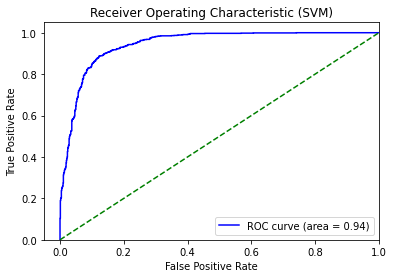

In [23]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

In [24]:
start = timer.time()
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_logit = logit_model.predict(X_test_std)
y_logit_prob = logit_model.predict_proba(X_test_std)

Finished training within 0.06 seconds


In [26]:
print("Classification report for LR: \n{}".format(classification_report(y_test,y_logit)))
print("Confusion matrix for LR: \n{}".format(confusion_matrix(y_test,y_logit)))
print("Accuracy score for LR: {:.2f}".format(accuracy_score(y_test,y_logit)))
# calculate precision, recall, and f1 scores
prec_logit = precision_score(y_test,y_logit)
rec_logit = recall_score(y_test,y_logit)
f1_logit = f1_score(y_test,y_logit)
print("Precision score for LR: {:.2f}".format(prec_logit))
print("Recall score for LR: {:.2f}".format(rec_logit))
print("F1 score for LR: {:.2f}".format(f1_logit))


Classification report for LR: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       948
           1       0.83      0.85      0.84       997

    accuracy                           0.83      1945
   macro avg       0.83      0.83      0.83      1945
weighted avg       0.83      0.83      0.83      1945

Confusion matrix for LR: 
[[771 177]
 [149 848]]
Accuracy score for LR: 0.83
Precision score for LR: 0.83
Recall score for LR: 0.85
F1 score for LR: 0.84


In [28]:
# calculate sensitivity, specificity, and auc
sens_logit,spec_logit = sensitivity_specificity(y_test,y_logit)
fpr, tpr, _ = roc_curve(y_test,  y_logit_prob[:,1])
auc_logit = roc_auc_score(y_test, y_logit_prob[:,1])
print("Sensitivity score for LR: {:.2f}".format(sens_logit))
print("Specitivity score for LR: {:.2f}".format(spec_logit))
print("AUC score for LR: {:.2f}".format(auc_logit))

Sensitivity score for LR: 0.85
Specitivity score for LR: 0.81
AUC score for LR: 0.91


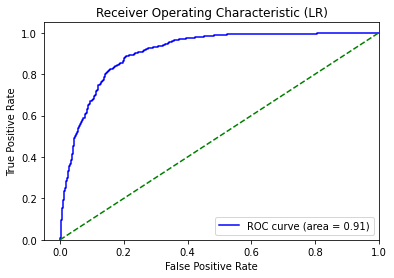

In [29]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_logit)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LR)')
ax.legend(loc="lower right")
plt.show()